The goal of this notebook is to create a student-teacher model where we first train a teacher on labeled data, and then use this teacher model to label more data, then we swap out the teacher with a student and train again over all the samples. 
- Try AutoAugment/RandAugment
- Add regularization
- Resampling  
  - Make resampling func for unlab_ds
- Create new unlab_ds without previous findings

# Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import datetime
import time
import os
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from pipeline import create_dataset, split_and_create_dataset, prepare_for_training
from utils import show_image, class_distribution, print_split_info, unpipe
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
project_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/labeled_ttv/')
unlab_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/unlabeled_ttv/')
model_name = "teacher1"
log_dir = "./logs/{}/{}".format(project_time, model_name)

conf = {
    # Dataset
    "data_dir": data_dir,
    "unlab_dir": unlab_dir,
    "log_dir": log_dir,
    "cache_dir": "./cache",
    "ds_info": 'hypkva',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "aug_mult": 0.3,
    "resample": False,
    "class_weight": False,
    "shuffle_buffer_size": 2000,        # 0=no shuffling
    "seed": 2511,
    "neg_class": None,                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model_name": model_name,
    "model": 'EfficientNetB0',
    "dropout": 0.1,
    "num_epochs": 1,
    "batch_size": 128,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',     # sigmoid for binary ds
    # Callbacks
    "learning_schedule": True,
    "decay_rate": 0.1,                 # higher number gives steeper lr dropoff
    "checkpoint": False,
    "early_stopp": True,
    "early_stopp_patience": 6,
    # Misc
    "verbosity": 1
    }

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [4]:
clean_train, train_ds, test_ds, val_ds = create_dataset(conf)

class_names = conf["class_names"]

barretts-short-segment      :   53 | 0.50%
retroflex-stomach           :  764 | 7.17%
ulcerative-colitis-0-1      :   35 | 0.33%
ulcerative-colitis-grade-3  :  133 | 1.25%
esophagitis-b-d             :  260 | 2.44%
dyed-resection-margins      :  989 | 9.28%
hemorrhoids                 :    6 | 0.06%
normal-z-line               :  932 | 8.74%
esophagitis-a               :  403 | 3.78%
ulcerative-colitis-1-2      :   11 | 0.10%
barretts                    :   41 | 0.38%
bbps-2-3                    : 1148 | 10.77%
ileum                       :    9 | 0.08%
bbps-0-1                    :  646 | 6.06%
impacted-stool              :  131 | 1.23%
cecum                       : 1009 | 9.46%
ulcerative-colitis-grade-2  :  443 | 4.15%
ulcerative-colitis-2-3      :   28 | 0.26%
pylorus                     :  999 | 9.37%
retroflex-rectum            :  391 | 3.67%
ulcerative-colitis-grade-1  :  201 | 1.89%
polyps                      : 1028 | 9.64%
dyed-lifted-polyps          : 1002 | 9.40%

Total num

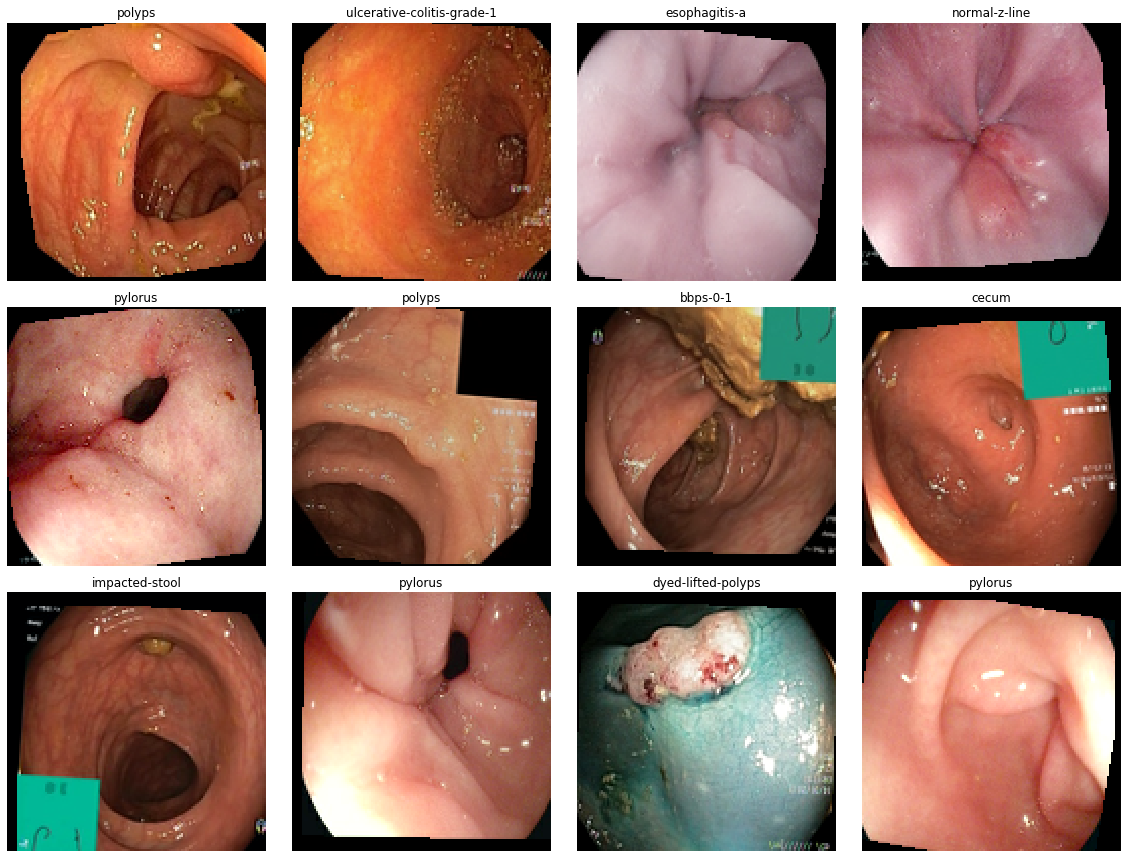

In [5]:
from utils import checkout_dataset

# Show some images from training dataset - mainly to verify augmentation and distribution
# add params for title and log_dir for savefig
checkout_dataset(train_ds, conf)

# Step 1: Train a teacher model on labeled images

In [6]:
from tensorflow.python.keras.models import Model, load_model
from create_model import create_model

teacher_model = create_model(conf)

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                11799     
Total params: 4,717,235
Trainable params: 4,675,219
Non-trainable params: 42,016
_________________________________________

### Callbacks

In [7]:
from create_model import create_callbacks

callbacks = create_callbacks(conf)

In [8]:
from utils import write_to_file

write_to_file(conf, conf, "conf") #ignore stupid arguments

#### Class weight

In [9]:
from utils import get_class_weights

class_weights = get_class_weights(train_ds, conf)

### Train the teacher model

In [10]:
start_time = time.time()

teacher_history = teacher_model.fit(
        train_ds,
        steps_per_epoch = conf["steps"]["train"],
        epochs = conf["num_epochs"],
        validation_data = test_ds,
        validation_steps = conf["steps"]["test"],
        validation_freq = 1,
        class_weight = class_weights,
        callbacks = callbacks,
        verbose = 1
)

print ("Time spent on training: {}".format(time.time() - start_time))

# Save the metrics from training
f = open(conf["log_dir"]+"/teacher_history.txt","w")
f.write(str(teacher_history.history))
f.close()

Train for 58 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
58/58 [==============================] - 23s 390ms/step - loss: 1.6083 - sparse_categorical_accuracy: 0.5555 - val_loss: 173752.0964 - val_sparse_categorical_accuracy: 0.0898
Time spent on training: 22.882668256759644


### Save or restore a model

In [11]:
teacher_model.save(conf["log_dir"]+'/model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./logs/20200513-162625/teacher1/model/assets


## Evaluate the model

In [12]:
teacher_evaluate = teacher_model.evaluate(val_ds, verbose=2, steps=conf["steps"]["val"])

write_to_file(teacher_evaluate, conf, "evaluate_val")

12/12 - 1s - loss: 171082.7240 - sparse_categorical_accuracy: 0.0892


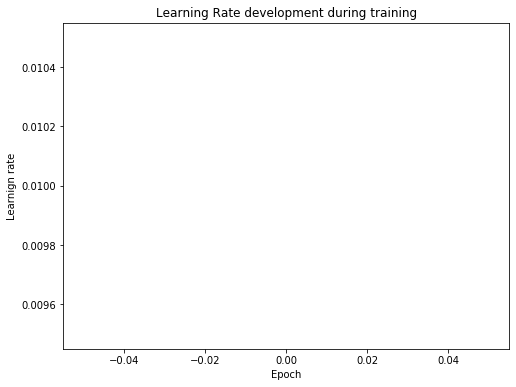

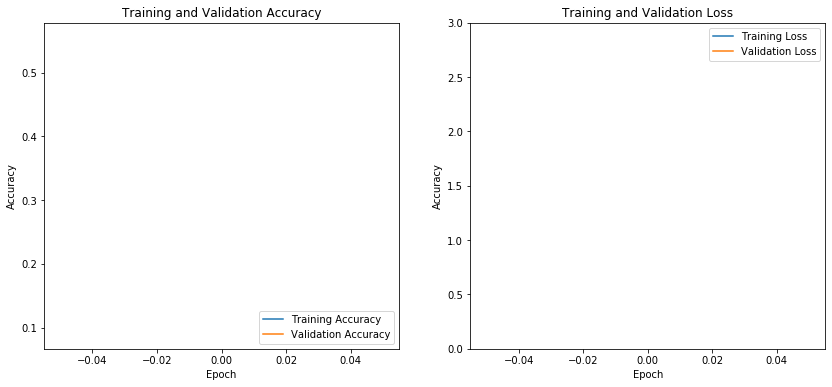

In [13]:
from model_evaluation import plot_lr_and_accuracy

plot_lr_and_accuracy(teacher_history, conf)

In [14]:
from model_evaluation import display_classification_report
from model_evaluation import get_metrics, get_confusion_matrix
from model_evaluation import plot_confusion_matrix

In [15]:
eval_ds = unpipe(val_ds, conf["sizes"]["val"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)

true_labels = list(eval_ds[:,1])

predictions = teacher_model.predict(eval_images, verbose=1)

pred_confidence = [np.max(pred) for pred in predictions]
pred_labels = [np.argmax(pred) for pred in predictions]

1610/1610 [==============================] - 2s 1ms/sample


In [16]:
get_metrics(true_labels, pred_labels)

Accuracy: 0.087
Precision: 0.0076
Recall: 0.087
F1 Score: 0.0139


/home/henriklg/anaconda3/envs/TF2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
display_classification_report(
        true_labels, 
        pred_labels, 
        range(conf["num_classes"]), 
        target_names=conf["class_names"]
)

                            precision    recall  f1-score   support

    barretts-short-segment      0.000     0.000     0.000         8
         retroflex-stomach      0.000     0.000     0.000       115
    ulcerative-colitis-0-1      0.000     0.000     0.000         6
ulcerative-colitis-grade-3      0.000     0.000     0.000        20
           esophagitis-b-d      0.000     0.000     0.000        39
    dyed-resection-margins      0.000     0.000     0.000       149
               hemorrhoids      0.000     0.000     0.000         1
             normal-z-line      0.087     1.000     0.160       140
             esophagitis-a      0.000     0.000     0.000        61
    ulcerative-colitis-1-2      0.000     0.000     0.000         2
                  barretts      0.000     0.000     0.000         7
                  bbps-2-3      0.000     0.000     0.000       173
                     ileum      0.000     0.000     0.000         2
                  bbps-0-1      0.000     0.000

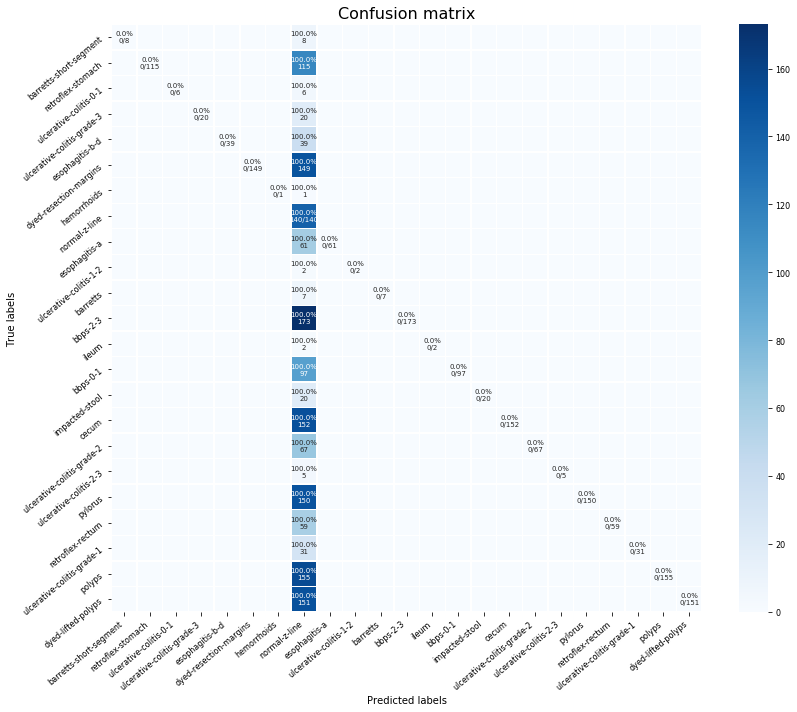

In [18]:
cm = get_confusion_matrix(true_labels, pred_labels)

plot_confusion_matrix(cm, log_dir, conf["class_names"], figsize=(12,10))

Display grid of some random samples from validation data with the prediction confidence

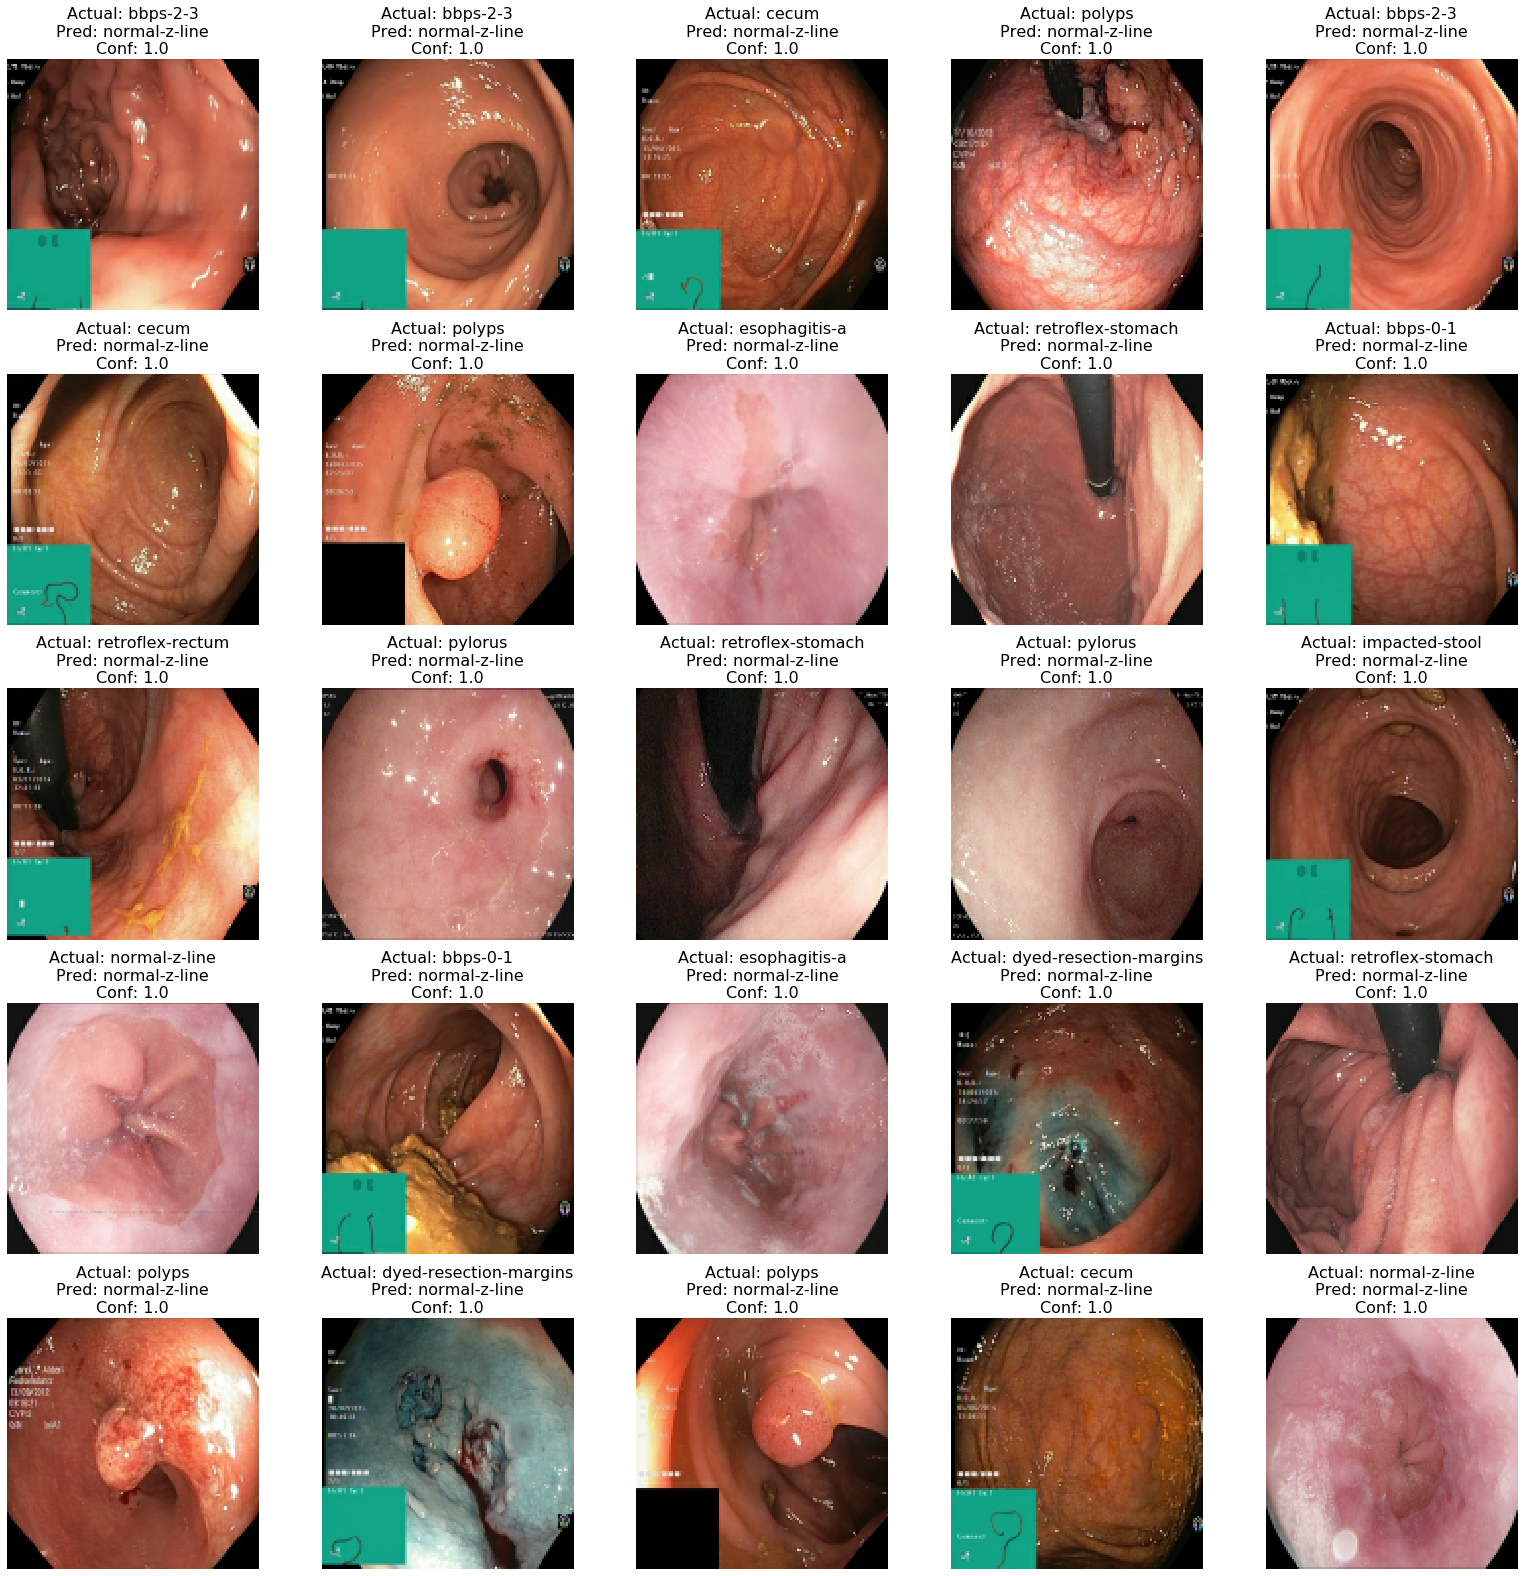

In [19]:
from model_evaluation import show_dataset_predictions

show_dataset_predictions(
        true_labels,
        pred_labels,
        pred_confidence,
        eval_images,
        conf,
)

# Step 2: use the teacher to generate pseudo labels on unlabeled images

### Read in the unlabeled dataset

In [42]:
from pipeline import create_unlab_ds

unlab_ds, unlab_size = create_unlab_ds(conf)

Loaded 99417 images into unlabeled_ds.


## Run predictions on all unlabeled images
Using 'append to list and convert to tensor'-method

In [43]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from utils import print_bar_chart

pred_confidence = 0.60
new_findings = 0
count = 0
img_list = []
pred_list = []
name_list = []

In [44]:
def get_tqdm(unlab_size, count, new_findings):
    tqdm_predicting = tqdm(total=unlab_size, desc='Predicting', position=0, initial=count)
    tqdm_findings = tqdm(total=unlab_size, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_findings)
    
    return tqdm_predicting, tqdm_findings

In [45]:
total_time = time.time()

tqdm_predicting, tqdm_findings = get_tqdm(unlab_size, count, new_findings)

print ("Press 'Interrupt Kernel' to save and exit.")
try:
    for count, (image,path) in enumerate(unlab_ds, start=count):
        img = np.expand_dims(image, 0)
        pred = teacher_model.predict(img)
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.uint8)

            lab_list.append(pred_idx)
            pred_list.append(highest_pred)
            name_list.append(path)
            
            # Clear old bar chart, generate new one and refresh the tqdm progress bars
            # NB, tqdm run-timer is also reset, unfortunately
            if not new_findings%500 and new_findings>100:
                clear_output(wait=True)
                tqdm_predicting, tqdm_findings = get_tqdm(unlab_size, count, new_findings)
                lab_array = np.asarray(lab_list, dtype=np.uint8)
                findings = np.bincount(lab_array, minlength=int(conf["num_classes"]))
                print_bar_chart([findings], conf)
                
            new_findings += 1
            tqdm_findings.update(1)
        tqdm_predicting.update(1)
except KeyboardInterrupt:
    print ("Exiting")

finally:
    print ("\nTotal run time: {:.3f} s".format( time.time() - total_time ))
    print ("Found {} new samples in unlabeled_ds after looking at {} images.".format(new_findings, count))

Press 'Interrupt Kernel' to save and exit.
Exiting

Total run time: 2.088 s
Found 74 new samples in unlabeled_ds after looking at 74 images.


Plot bar chart and save it (optional)

In [46]:
lab_array = np.asarray(lab_list, dtype=np.uint8)
findings = np.bincount(lab_array, minlength=int(conf["num_classes"]))

print_bar_chart(
    data=[findings],
    conf=conf,
    title=None,
    fname="bar_chart-unlab",
    figsize=(16,7)
)
clear_output(wait=False)

Save the image and labels list as pickle dump (optional)

## Inspect the classified images

### Sort new samples after prediction confidence

In [47]:
from utils import custom_sort

pred_list, lab_list, name_list = custom_sort(pred_list, lab_list, name_list)

### Display samples from all classes

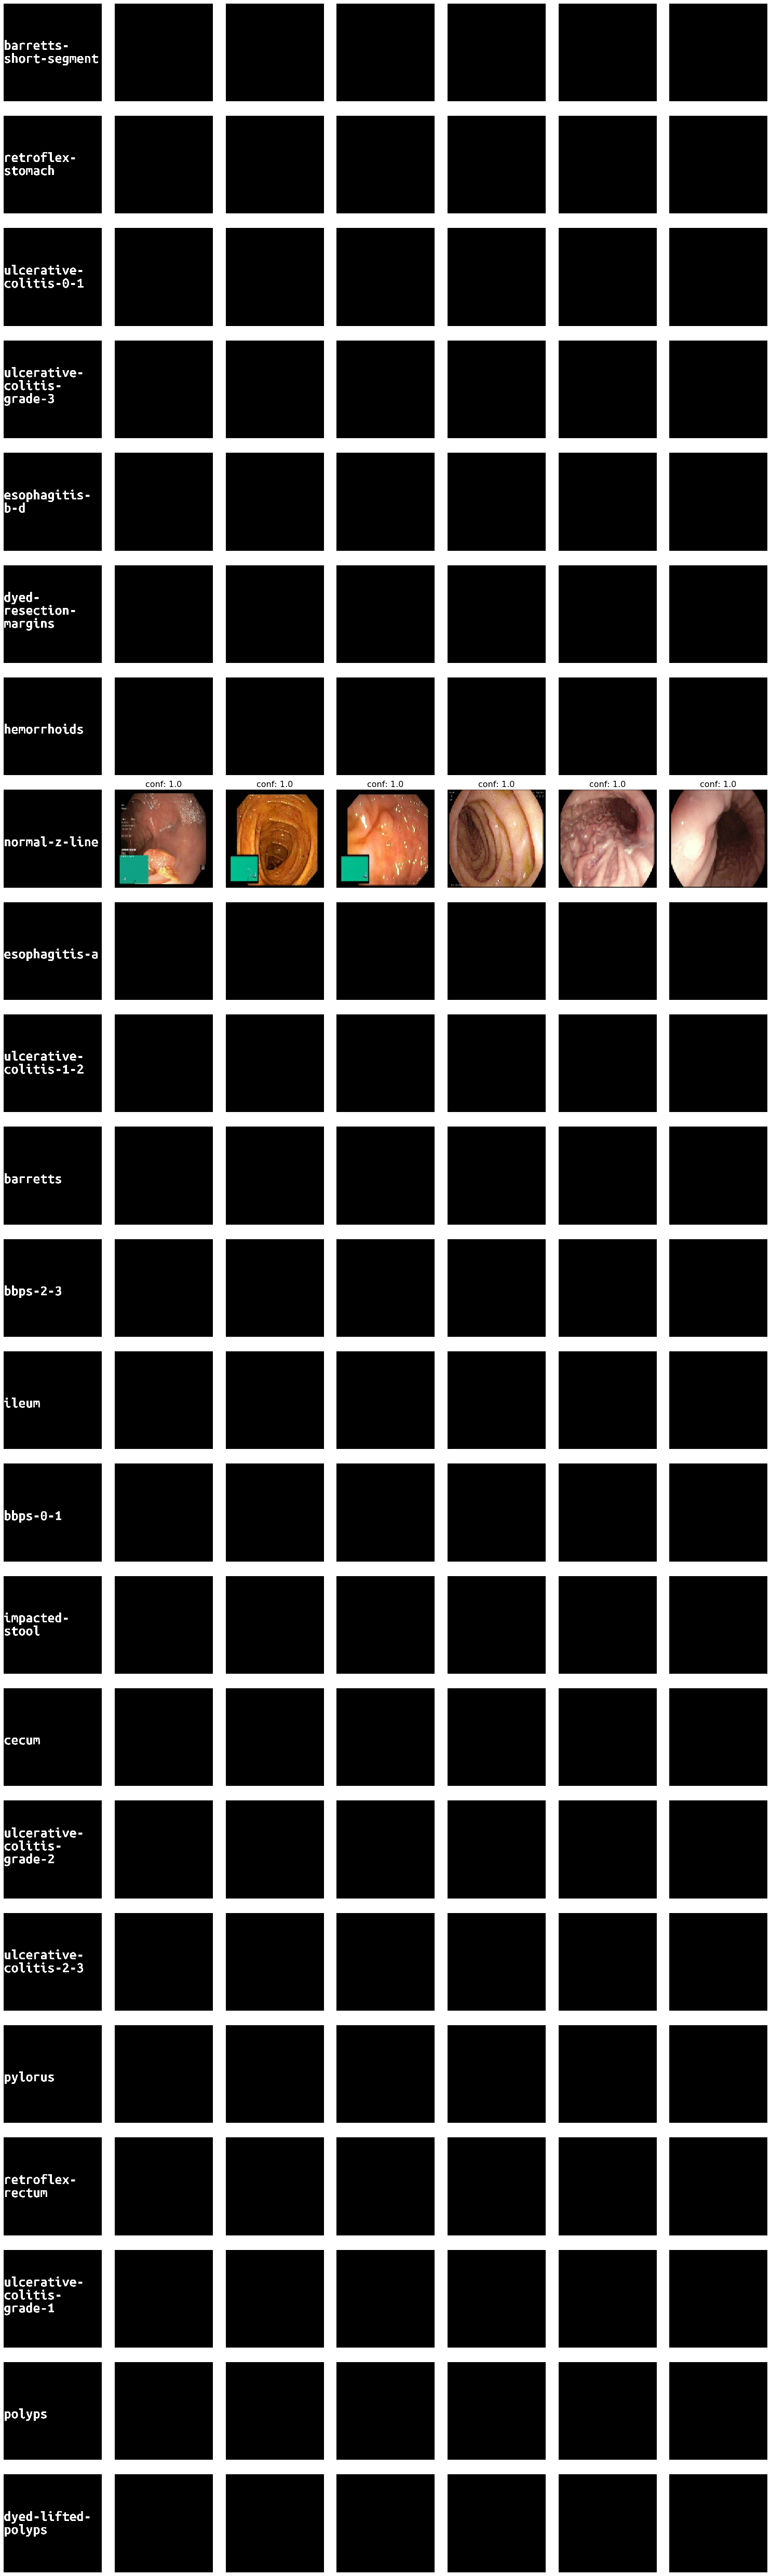

In [48]:
from utils import checkout_unlab

unlab = [pred_list, lab_list, name_list]
checkout_unlab(unlab, conf)

### Print grid of images from one of the classes

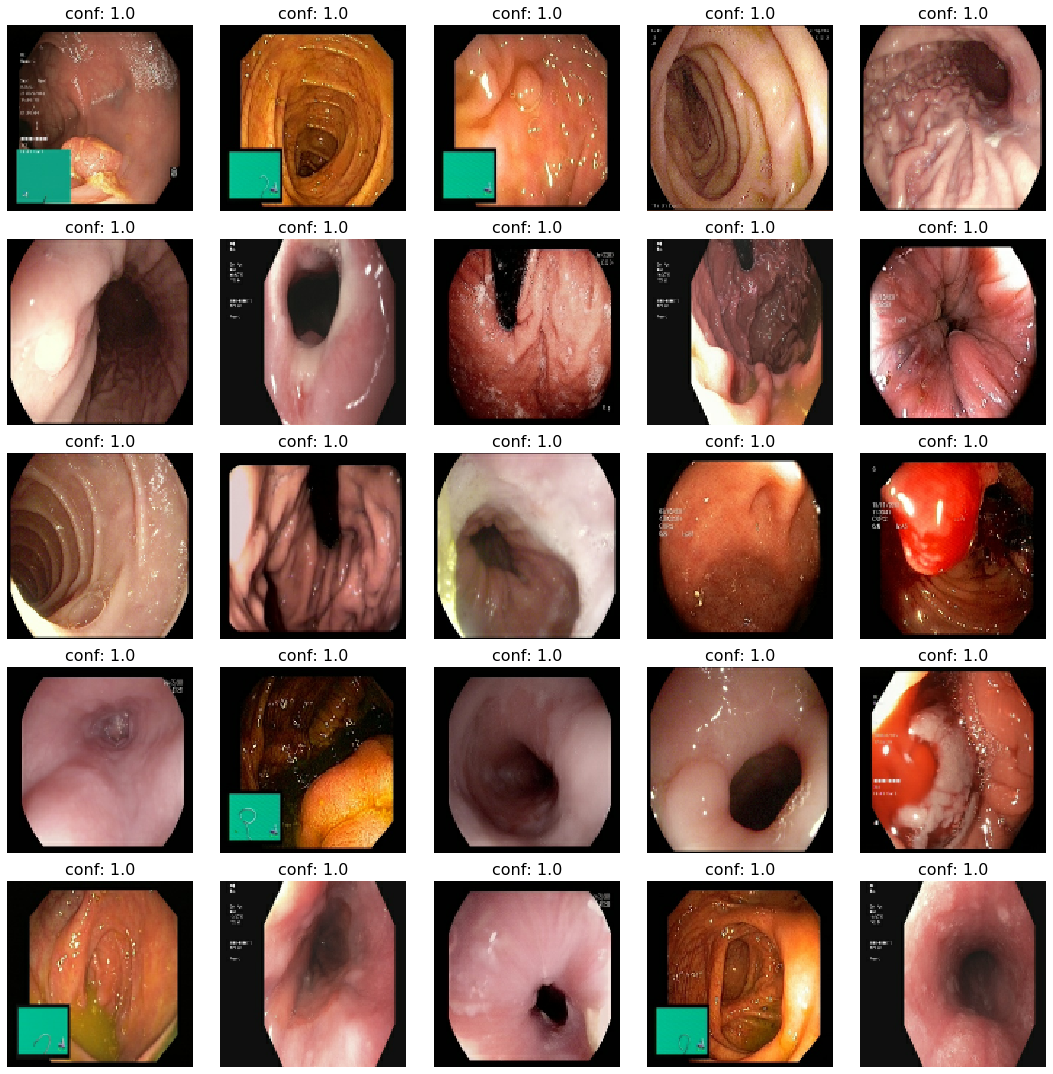

In [49]:
from utils import checkout_class

checkout_class("normal-z-line", unlab, conf)

### Resample the new findings from unlabeled dataset to "fit" original distribution of samples per class

In [50]:
from utils import resample_unlab

new_findings, new_filepaths = resample_unlab(clean_train, unlab, conf)

Limit set by bbps-2-3 with 803 samples
----------------------------------------
barretts-short-segment     : added 0/0 samples.
retroflex-stomach          : added 0/0 samples.
ulcerative-colitis-0-1     : added 0/0 samples.
ulcerative-colitis-grade-3 : added 0/0 samples.
esophagitis-b-d            : added 0/0 samples.
dyed-resection-margins     : added 0/0 samples.
hemorrhoids                : added 0/0 samples.
normal-z-line              : added 74/74 samples.
esophagitis-a              : added 0/0 samples.
ulcerative-colitis-1-2     : added 0/0 samples.
barretts                   : added 0/0 samples.
bbps-2-3                   : added 0/0 samples.
ileum                      : added 0/0 samples.
bbps-0-1                   : added 0/0 samples.
impacted-stool             : added 0/0 samples.
cecum                      : added 0/0 samples.
ulcerative-colitis-grade-2 : added 0/0 samples.
ulcerative-colitis-2-3     : added 0/0 samples.
pylorus                    : added 0/0 samples.
retrof

### Convert image and label lists to tensors and combine with training_ds to create a new dataset for training

In [51]:
findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)

In [52]:
_, count_iter0 = class_distribution(clean_train, conf["num_classes"])

In [53]:
# combine with old ds
combined_ds = clean_train.concatenate(findings_tensor)

In [54]:
_, count_iter1 = class_distribution(combined_ds, conf["num_classes"])

History of class distribution

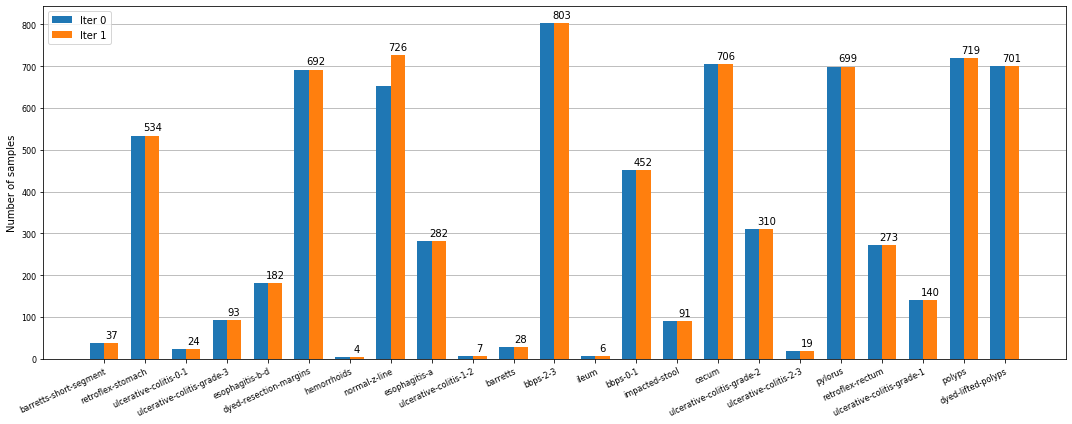

In [55]:
from utils import print_bar_chart

print_bar_chart(
    data=[count_iter0, count_iter1],
    conf=conf,
    title=None,
    fname="bar_chart-pseudo"
)

### 'Refresh' unlabeled dataset by extracting samples already used

In [57]:
from utils import reduce_dataset

new_unlab_ds = reduce_dataset(unlab_ds, new_filepaths)
new_unlab_size = unlab_size - len(new_filepaths)

### One final sanity check

In [58]:
print ("original train size:", conf["sizes"]["train"])
added_findings = len(new_findings[1])
print ("added findings:", added_findings)
new_train_size = conf["sizes"]["train"]+added_findings
print ("new train size:", new_train_size)

###################
# for cnt, (img, lab) in enumerate(new_unlab_ds, start=1): pass
print ("\ntotal original unlabeled images: {}".format(unlab_size))
print ("updated total for unlabeled images: {}".format(new_unlab_size))

original train size: 7454
added findings: 74
new train size: 7528

total original unlabeled images: 99417
updated total for unlabeled images: 99343


# Step 3: Train a student model on the combination of labeled images and pseudo labeled images

Now we have trained a teacher model, and used that model to predict on unlabeled dataset to create more samples with psudo-labels.  
It's time for swapping the teacher with the student!

In [ ]:
# save teacher conf
teacher_conf = conf

# Make changes
model_name = "student1"
log_dir = "./logs/{}/{}/".format(project_time, model_name)

conf["log_dir"] = log_dir
conf["model"] = 'EfficientNetB1'
conf["num_epochs"] = 20

In [ ]:
pseudo_train = prepare_for_training(
        ds=combined_ds, 
        ds_name='pseudo_train',
        num_classes=conf["num_classes"],
        conf=conf,
        cache=True
    )

In [ ]:
# By using LearnignRateScheduler
initial_learning_rate = conf["learning_rate"]
decay_steps = conf["train_size"] // conf["batch_size"]
batch_size = conf['batch_size']
decay_rate = conf['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss', 
                              verbose=1, patience=conf["early_stopp_patience"], 
                              restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', 
                                monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]
if conf["early_stopp"]: callbacks.append(earlystopp_cb)
if conf["learning_schedule"]: callbacks.append(lr_schedule_cb)
if conf["checkpoint"]: callbacks.append(checkpoint_cb)

# Write conf and params dictionary to text file
list_of_strings = [ '{:20} : {}'.format(key, conf[key]) for key in conf ]
with open(log_dir+"/conf.txt","w") as f:
    [ f.write(f'{st}\n') for st in list_of_strings ]
f.close()

In [ ]:
if conf["model"] == 'EfficientNetB0': 
    from efficientnet import EfficientNetB0 as EfficientNet # 5.3M params
elif conf["model"] == 'EfficientNetB1': 
    from efficientnet import EfficientNetB1 as EfficientNet # 7.8M params
elif conf["model"] == 'EfficientNetB2':
    from efficientnet import EfficientNetB2 as EfficientNet # 9.2M params
elif conf["model"] == 'EfficientNetB3':
    from efficientnet import EfficientNetB3 as EfficientNet # 12M params

In [ ]:
# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True

# Define model
stud_model = Sequential()
stud_model.add(efficientnet_base)
stud_model.add(layers.GlobalAveragePooling2D())
stud_model.add(layers.Dropout(0.3))
stud_model.add(layers.Dense(512, activation='relu'))
stud_model.add(layers.Dropout(0.3))
stud_model.add(layers.Dense(params["num_classes"], activation=conf["final_activation"]))

if conf['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=conf["learning_rate"])
elif conf['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=conf["learning_rate"])

stud_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
stud_history = stud_model.fit(
    pseudo_train,
    steps_per_epoch = params["train_size"] // conf["batch_size"], 
    epochs = conf["num_epochs"],
    validation_data = test_ds, # what to use for validation data?
    validation_steps = params["test_size"] // conf["batch_size"],
    validation_freq = 1,
    callbacks = callbacks
)

In [ ]:
# Save the model
model_name = '{}x{}x{}_{}_{}'.format(conf["num_epochs"], conf["batch_size"], 
                                     conf["img_shape"][1], conf["ds_info"], conf["model"])
best_acc =  str(stud_history.history["val_sparse_categorical_accuracy"][-1])[2:4]
stud_model.save(log_dir+'/{}.h5'.format(model_name+'_'+best_acc))

In [ ]:
eval_ds = unpipe(val_ds, params["val_size"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)

true_labels = list(eval_ds[:,1])

predictions = stud_model.predict(eval_images, verbose=1)

predicted_confidence = [np.max(pred) for pred in predictions]
predicted_labels = [np.argmax(pred) for pred in predictions]

In [ ]:
display_classification_report(
        true_labels, 
        predicted_labels, 
        range(params["num_classes"]), 
        target_names=params["class_names"]
)

In [ ]:
cm = get_confusion_matrix(true_labels, predicted_labels)

plot_confusion_matrix(cm, log_dir, params["class_names"], figsize=(12,10))

In [ ]:
stud_evaluate = stud_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // conf["batch_size"])

# Write evaluate dictionary to text file
f = open(log_dir+"/val_evaluate.txt","w")
f.write( str(stud_evaluate) )
f.close()

In [ ]:
acc = stud_history.history['sparse_categorical_accuracy']
val_acc = stud_history.history['val_sparse_categorical_accuracy']

loss = stud_history.history['loss']
val_loss = stud_history.history['val_loss']

if conf["learning_schedule"]: lr = stud_history.history['lr']
epochs_range = range(stud_history.epoch[-1]+1)

In [ ]:
if conf["learning_schedule"]:
    # Plot the learning rate
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, lr, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learnign rate')
    plt.title('Learning Rate development during training');
    plt.savefig(log_dir+'/learning_rate.pdf', format='pdf')

In [ ]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.pdf', format='pdf')
plt.show()

Display grid of some random samples from validation data with the prediction confidence

In [ ]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(22, 22)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = params["class_names"][true_labels[img_idx]]
        lab = params["class_names"][predicted_labels[img_idx]]
        pred = np.round(predicted_confidence[img_idx], 2)
        
        title = 'Actual: '+actual+'\nPred: '+lab+ '\nConf: '+str(pred)
        ax[i][j].axis('off')
        ax[i][j].set_title(title)
        ax[i][j].imshow(eval_images[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.savefig(log_dir+"/model_predictions-val.pdf", format="pdf")

# Step 3.2: use the teacher to generate pseudo labels on unlabeled images
unlab_ds = `new_unlabeled`

In [ ]:
pred_confidence = 0.75
new_findings = 0
count = 0
img_list = []
lab_list = []
pred_list = []
path_list = []

In [ ]:
total_time = time.time()

tqdm_predicting = tqdm(total=ds_size_unlab, desc='Predicting', position=0, initial=count) 
tqdm_findings = tqdm(total=ds_size_unlab, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_findings)

print ("Press 'Interrupt Kernel' to save and exit.")
try:
    for count, (image,path) in enumerate(new_unlabeled, start=count):
        img = np.expand_dims(image, 0)
        pred = teacher_model.predict(img)
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)

            img_list.append(image)
            lab_list.append(pred_idx)
            pred_list.append(highest_pred)
            path_list.append(path)
            
            # Clear old bar chart, generate new one and refresh the tqdm progress bars
            # NB, tqdm run-timer is also reset, unfortunately
            if not new_findings%500:
                clear_output(wait=True)
                tqdm_predicting = tqdm(total=ds_size_unlab, desc='Predicting', position=0, initial=count)
                tqdm_findings = tqdm(total=ds_size_unlab, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_findings)
                print_bar_chart(lab_list, new_findings, count, params)
                
            new_findings += 1
            tqdm_findings.update(1)
        tqdm_predicting.update(1)
except KeyboardInterrupt:
    print ("Exiting")

finally:
    print ("\nTotal run time: {:.3f} s".format( time.time() - total_time ))
    print ("Found {} new samples in unlabeled_ds after looking at {} images.".format(new_findings, count))

In [ ]:
# Save the bar chart
print_bar_chart(lab_list, new_findings, count, params, log_dir=log_dir, figsize=(15,10))
clear_output(wait=False)

In [ ]:
pred_list, lab_list, img_list, path_list = custom_sort(pred_list, lab_list, img_list, path_list)

In [ ]:
unlab = [pred_list, lab_list, img_list]
checkout_unlab(unlab, conf, params, log_dir)

In [ ]:
checkout_class("polyps", unlab, conf, params, log_dir)

In [ ]:
# Get the _last_ distribution used for training - NB: this must be updated for each teacher/student iteration
# _, orig_dist = class_distribution(clean_train, params["num_classes"])
orig_dist = data2                                   # !!!!!!!!!!!!!!!!!!

num_to_match = np.max(orig_dist)

idx_to_match = np.argmax(orig_dist)
print ('Limit set by {} with {} samples'.format(params["class_names"][idx_to_match], int(num_to_match)))
print ("-"*40)

new_findings = ([], [])
new_findings_filepaths = []
lab_arr = np.asarray(lab_list, dtype=np.uint8)

getto_list = []

for class_idx in range(params["num_classes"]):
    # how many samples already in this class
    in_count = orig_dist[class_idx]                  # !!!!!!!!!!!!!!!!!
    
    indexes = np.where(lab_arr==class_idx)[0]
    num_new_findings = len(indexes)
    
    for count, idx in enumerate(indexes, start=1):
        if in_count >= num_to_match:
            count -= 1 # reduce by one cuz of enumerate updates index early
            break
        new_findings[0].append(img_list[idx])         # image
        new_findings[1].append(lab_list[idx])         # label
        new_findings_filepaths.append(path_list[idx]) # filepath
        in_count += 1
        
    getto_list.append(count)
    print ("{:27}: added {}/{} samples.".format(params["class_names"][class_idx], count, num_new_findings))

In [ ]:
print ("original train size:", params["train_size"])

added_findings = len(new_findings[1])
print ("added findings:", added_findings)

new_train_size = params["train_size"]+added_findings
print ("new train size:", new_train_size)

# this is wrong. needs to be fixed

In [ ]:
findings_tensor = tf.data.Dataset.from_tensor_slices(new_findings)

In [ ]:
# count for iteration 2
print (data2)

In [ ]:
# combine with old ds
combined_ds2 = combined_ds.concatenate(findings_tensor)

In [ ]:
_, count_iter2 = class_distribution(combined_ds2, params["num_classes"])
print (count_iter2)

In [ ]:
count_iter2 = [] 
for i in range(0, len(data2)): 
    count_iter2.append(int(data2[i] + getto_list[i]))

In [ ]:
print (count_iter2)

In [ ]:
# data1 = countx
# data2 = county
data3 = count_iter2

x = np.arange(params["num_classes"])
width = 0.2

fig, ax = plt.subplots(figsize=(12,5))
rects1 = ax.bar(x-width, data1, width, label='Iter 0')
rects2 = ax.bar(x,       data2, width, label='Iter 1')
rects3 = ax.bar(x+width, data3, width, label='Iter 2')

ax.set_ylabel('Number of samples')
# title_string = ""
# ax.set_title(title_string)
ax.set_xticks(x)
ax.set_xticklabels(params["class_names"])
ax.set_axisbelow(True)
ax.legend();

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=25, ha="right",
             rotation_mode="anchor")
plt.grid(axis='y')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(rect.get_height())
        ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# autolabel(rects1)
# autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
if log_dir:
    plt.savefig(log_dir+'/distribution_bar_chart.pdf', format='pdf')
plt.show()

In [ ]:
ds_size_unlab

In [ ]:
def remove_samples(img, path):
    bool_list = tf.equal(path, new_findings_filepaths)
    in_list = tf.math.count_nonzero(bool_list) > 0
    return not in_list

newer_unlabeled = new_unlabeled.filter(remove_samples)

for cnt, (img, path) in enumerate(newer_unlabeled, start=1):
    pass

print ("New ds_size_unlab:", cnt)
ds_size_unlab2 = cnt

# Step 4: Iterate this algorithm a few times by treating the student as a teacher to relabel the unlabeled data and training a new student